In [71]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Driver ID is the driver's unique ID

Driver workday ID is the driver's unique ID for that specific workday

Location type id (location type = 1 pickup and 2 = delivery) - Usually, the drivers do all the pickups at the same time in the morning

Location ID is the unique ID for each location

Earliest is the earliest time the stop can be served

Latest is the latest time the stop can be served

Dispatched at is the time we dispatched it to the driver - the ordering of the dispatched at tells which sequence we planned the route to be done in

Arrived at is the time the driver arrived

Completed_at is the time the driver completed the stop

Estimated time on location is the time we had planned them to use on the location

In [ ]:
dtypes = {'ID': 'int64', 'Day': 'int64', 'Type': 'int64', 'Location': 'int64', 'Earliest': 'datetime64', 'Latest': 'datetime64', 'Dispatched':'datetime64', 'Arrived': 'datetime64', 'Completed':'datetime64', 'Lat':'float64', 'Long':'float64', 'Est.time':'int64'}

data_customers = pd.read_csv('Dataset.csv', sep=';')

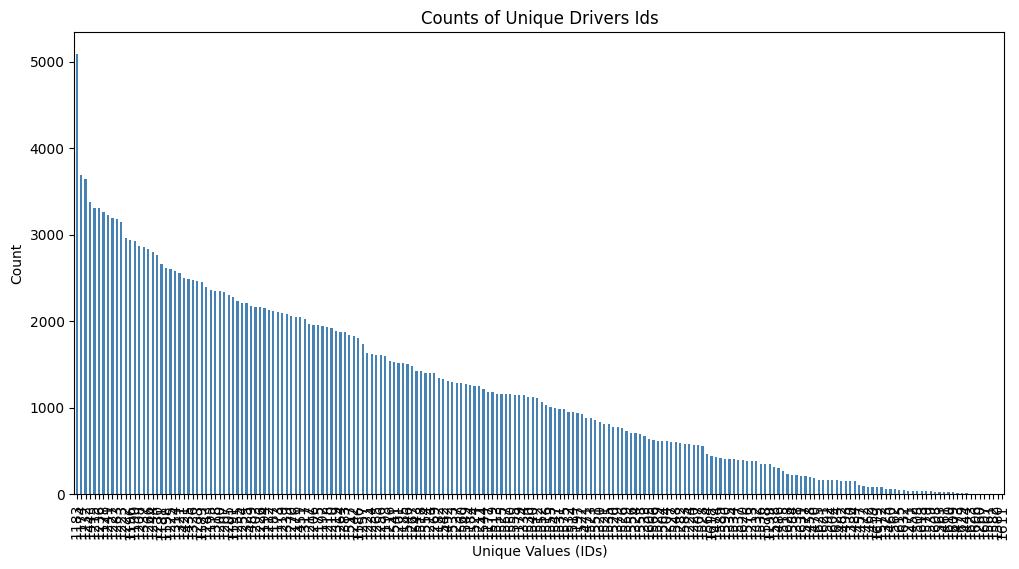

In [8]:
plt.figure(figsize=(12, 6))
unique_values_ID.plot(kind='bar', color='steelblue', figsize=(12, 6))
plt.xlabel('Unique Values (IDs)')
plt.ylabel('Count')
plt.title('Counts of Unique Drivers Ids')
plt.xticks(rotation=90)
plt.show()

In [ ]:
unique_values_day = data_customers['Day'].value_counts()
print("Unique values in the row:", unique_values_day)

In [ ]:
plt.figure(figsize=(12, 6))
unique_values_day.plot(kind='bar', color='steelblue', figsize=(12, 6))
plt.xlabel('Unique Values (IDs)')
plt.ylabel('Count')
plt.title('Counts of Unique drivers IDs for that specific workday')
plt.xticks(rotation=90)
plt.show()

In [ ]:
pickups = data_customers[data_customers['Type']==1]
unique_values_pickups = pickups['Location'].value_counts()

print(unique_values_pickups)

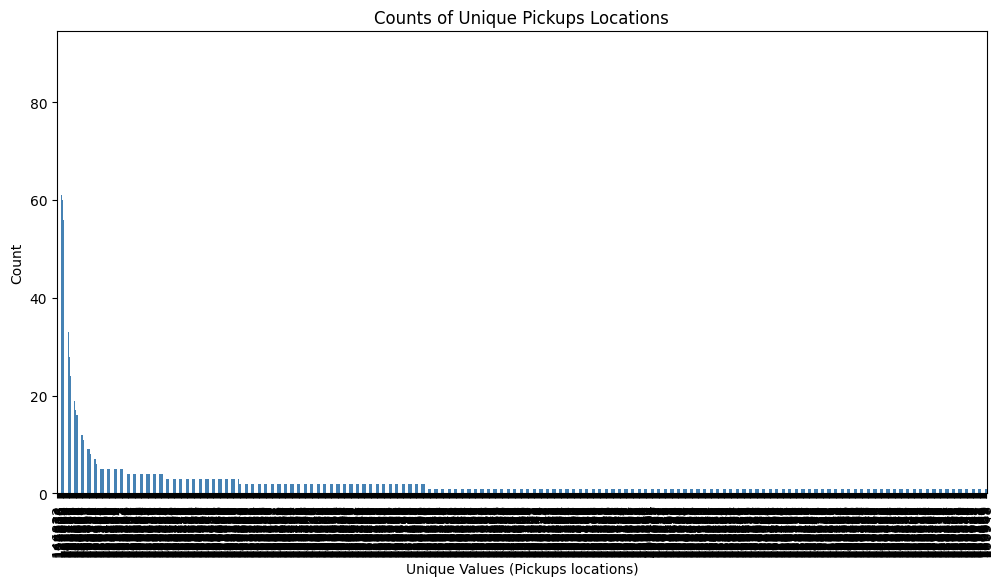

In [17]:
plt.figure(figsize=(12, 6))
unique_values_pickups[4:].plot(kind='bar', color='steelblue', figsize=(12, 6))
plt.xlabel('Unique Values (Pickups locations)')
plt.ylabel('Count')
plt.title('Counts of Unique Pickups Locations')
plt.xticks(rotation=90)
plt.show()

# Alysis of locations

In [ ]:
data_customers_deliver_with_na = data_customers[data_customers['Type']==2]
locations_unique = data_customers_deliver_with_na['Location'].value_counts()
locations_unique.head()

In [ ]:
plt.figure(figsize=(12, 6))
locations_unique[2:].plot(kind='bar', color='steelblue', figsize=(12, 6))
plt.title('Deliver location frequency')
plt.xticks(rotation=90)
plt.show()

## Timestep add UNIX timestamp for each column

In [ ]:
print(data_customers.isnull().any(axis=1).sum())
print(data_customers.isnull().sum())

In [ ]:
def add_ms_column(df, input_col):
    df[f'{input_col}_unixtime_mcs'] = pd.to_datetime(data_customers_no_na[input_col], format='mixed').apply(lambda x: int(x.timestamp() * 1000000))
    return df

data_customers_no_na = data_customers.dropna().reset_index(drop=True)
date_cols = ['Earliest', 'Latest', 'Dispatched', 'Arrived', 'Completed']
for col in date_cols:
    add_ms_column(data_customers_no_na, col)
data_customers_no_na.head()

### Take only deliveries and remove pickups

In [ ]:
data_customers_deliver = data_customers_no_na[data_customers_no_na['Type']==2]
print(len(data_customers_deliver))
data_customers_deliver.head()

## Arrival/Dispatching in TW

In [ ]:
print(sum(data_customers_deliver['Arrived_unixtime_mcs'] > data_customers_deliver['Latest_unixtime_mcs']))
print(sum(data_customers_deliver['Arrived_unixtime_mcs'] < data_customers_deliver['Earliest_unixtime_mcs']))
print(sum(data_customers_deliver['Dispatched_unixtime_mcs'] > data_customers_deliver['Latest_unixtime_mcs']))





In [ ]:
# Locations which were violated the most often (Driver arrived TOO LATE)

violated_locations = data_customers_deliver[data_customers_deliver['Arrived_unixtime_mcs'] > data_customers_deliver['Latest_unixtime_mcs']]['Location']
violated_locations.value_counts()



## Alysis of dispatched timestep

In [ ]:
data_customers_deliver['dispatch_hour'] = data_customers_deliver['Dispatched_unixtime_mcs'].apply(lambda x: datetime.fromtimestamp(x/1000000).hour)
popular_hour = data_customers_deliver['dispatch_hour'].mode()[0]
print(f"The most popular dispatch hour is: {popular_hour}")
dispatch_by_hour = data_customers_deliver['dispatch_hour'].value_counts().sort_index()
print("Dispatch counts by hour:")
print(dispatch_by_hour)

In [ ]:
data_customers_deliver['day_of_week'] = data_customers_deliver['Dispatched_unixtime_mcs'].apply(lambda x: datetime.fromtimestamp(x/1000000).strftime('%A'))

# Get dispatch counts by day of week
dispatch_by_day = data_customers_deliver['day_of_week'].value_counts()
print("Dispatch counts by day of week:")
print(dispatch_by_day)

In [ ]:
sorted_dispatched = data_customers_deliver.sort_values(by='Dispatched_unixtime_mcs', ascending=True)
print(sorted_dispatched.iloc[0], sorted_dispatched.iloc[-1])

In [82]:
data_stops = pd.read_csv('uni_molde_v2.csv', sep=',')

def add_ms_column(df, input_col):
    df[f'{input_col}_unixtime_mcs'] = pd.to_datetime(data_stops_no_na[input_col], format='mixed').apply(lambda x: int(x.timestamp() * 1000000))
    return df

data_stops_no_na = data_stops.dropna().reset_index(drop=True)
date_cols = ['stop_earliest', 'stop_latest', 'stop_dispatched_at', 'stop_arrived_at']
for col in date_cols:
    add_ms_column(data_stops_no_na, col)


sorted_data_stops = data_stops_no_na.sort_values(by='stop_dispatched_at_unixtime_mcs', ascending=True)

grouped_df = sorted_data_stops.groupby('driver_workday_id')[['driver_id', 'location_type_id', 'location_id', 'stop_dispatched_at', 'stop_dispatched_at_unixtime_mcs', 'stop_arrived_at_unixtime_mcs', 'stop_arrived_at', 'stop_earliest', 'stop_latest']].apply(lambda x: pd.Series({
    'driver_id': x['driver_id'].tolist(),
    'location_type_id': x['location_type_id'].tolist(),
    'location_id': x['location_id'].tolist(),
    'stop_dispatched_at': x['stop_dispatched_at'].tolist(),
    'stop_dispatched_at_unixtime_mcs': x['stop_dispatched_at_unixtime_mcs'].tolist(),
    'stop_arrived_at_unixtime_mcs': x['stop_arrived_at_unixtime_mcs'].tolist(),
    'stop_arrived_at': x['stop_arrived_at'].tolist(),
    'stop_earliest': x['stop_earliest'].tolist(),
    'stop_latest': x['stop_latest'].tolist(),
})).reset_index()

In [25]:
grouped_df = sorted_dispatched.groupby('Day')[['ID', 'Type', 'Location', 'Dispatched', 'Dispatched_unixtime_mcs', 'Arrived_unixtime_mcs', 'Arrived', 'Earliest', 'Latest']].apply(lambda x: pd.Series({
    'ID': x['ID'].tolist(),
    'Type': x['Type'].tolist(),
    'Location': x['Location'].tolist(),
    'Dispatched': x['Dispatched'].tolist(),
    'Dispatched_unixtime_mcs': x['Dispatched_unixtime_mcs'].tolist(),
    'Arrived_unixtime_mcs': x['Arrived_unixtime_mcs'].tolist(),
    'Arrived': x['Arrived'].tolist(),
    'Earliest': x['Earliest'].tolist(),
    'Latest': x['Latest'].tolist(),
})).reset_index()


In [27]:
len_routes = grouped_df['Location'].apply(lambda x: len(x))

In [ ]:
#check if drivers id are the same in one route
for i in grouped_df['ID']:
    if not all(x == i[0] for x in i):
            print('Not the same driver in the route')

for index, i in enumerate(grouped_df['Arrived_unixtime_mcs']):
    if not all(datetime.fromtimestamp(x/1000000).date() == datetime.fromtimestamp(i[0]/1000000).date() for x in i):
            print(f"Not the same date in the route {grouped_df.iloc[index]['Arrived']}, {grouped_df.iloc[index]['Dispatched']}, {grouped_df.iloc[index]['ID']},  {grouped_df.iloc[index]['Day']}, {grouped_df.iloc[index]['Location']}, {grouped_df.iloc[index]['Earliest']}, {grouped_df.iloc[index]['Latest']}")


In [ ]:
for index, i in enumerate(grouped_df['Dispatched_unixtime_mcs']):
    if not all(datetime.fromtimestamp(x/1000000).date() == datetime.fromtimestamp(i[0]/1000000).date() for x in i):
            print(f"Not the same date in the route {grouped_df.iloc[index]['Arrived']}, {grouped_df.iloc[index]['Dispatched']}, {grouped_df.iloc[index]['ID']},  {grouped_df.iloc[index]['Day']}, {grouped_df.iloc[index]['Location']}, {grouped_df.iloc[index]['Earliest']}, {grouped_df.iloc[index]['Latest']}")
            break

# Generate planned routes

In [70]:
## Dispatched during 30 minutes for one Day group (one driver)

df_routes_30mins = pd.DataFrame(columns=['Day', 'Location', 'Dispatched', 'Arrived'])
for index, row in grouped_df.iterrows():
    dispatched_list = row['Dispatched_unixtime_mcs']
    k = 0
    for i in range(len(dispatched_list) - 1):
        if (datetime.fromtimestamp(dispatched_list[i+1]/1000000) - datetime.fromtimestamp(dispatched_list[i]/1000000) >= timedelta(minutes=30)) :
            df_routes_30mins.loc[len(df_routes_30mins)] = [row['Day'], row['Location'][k: i+1], row['Dispatched'][k: i+1], row['Arrived'][k:i+1]]
            k = (i + 1)
        if (i == len(dispatched_list) - 2):
            df_routes_30mins.loc[len(df_routes_30mins)] = [row['Day'], row['Location'][k: len(dispatched_list)], row['Dispatched'][k: len(dispatched_list)], row['Arrived'][k:len(dispatched_list)]]

In [ ]:
#total routes number
print(len(df_routes_30mins['Location']))

route_length = np.array([len(set(i)) for i in df_routes_30mins['Location']])
unique_values_len, counts_len = np.unique(route_length, return_counts=True)

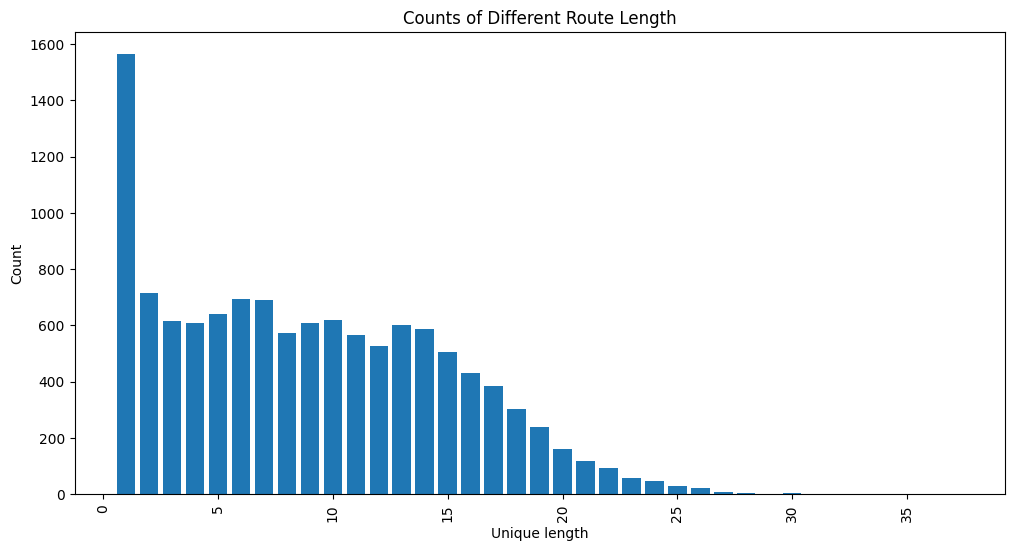

In [84]:
plt.figure(figsize=(12, 6))
plt.bar(unique_values_len, counts_len)
plt.xlabel('Unique length')
plt.ylabel('Count')
plt.title('Counts of Different Route Length')
plt.xticks(rotation=90)
plt.show()

In [85]:
len(route_length[route_length == 1])

1564

# Dataset stops

In [72]:
data_stops = pd.read_csv('uni_molde_v2.csv', sep=',')

In [ ]:
data_stops[(data_stops['prev_planned_lat'] != data_stops['prev_actual_lat'])]

In [56]:
len(data_stops)

106419

In [ ]:
def add_ms_column(df, input_col):
    df[f'{input_col}_unixtime_mcs'] = pd.to_datetime(data_stops_no_na[input_col], format='mixed').apply(lambda x: int(x.timestamp() * 1000000))
    return df

data_stops_no_na = data_stops.dropna().reset_index(drop=True) ## fulfill with something to not drop all picjups
date_cols = ['stop_earliest', 'stop_latest', 'stop_dispatched_at', 'stop_arrived_at', 'stop_completed_at']
for col in date_cols:
    add_ms_column(data_stops_no_na, col)

In [ ]:
#count locations in routes

import matplotlib.pyplot as plt
values = list(location_count.values())
unique_values = sorted(values)
plt.hist(values, bins=unique_values, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')

# Display the plot
plt.show()